In [1]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from tempfile import TemporaryDirectory

from Models import BigGenerator
from Tools import KL, batchKL

from tqdm import trange

print(torch.__version__)


1.4.0


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
from Experiments.foong_mixed import Setup
setup=Setup(device)
model=setup._model
param_count=setup.param_count
projection=setup.projection

In [4]:
theta_HMC=torch.load('mlruns/58/670a706db6c64c56ab1064708e7bc90c/artifacts/Foong_mixed_670a706db6c64c56ab1064708e7bc90c.pt').to(device)
sample_size=theta_HMC.shape[0]
sample_size

9999

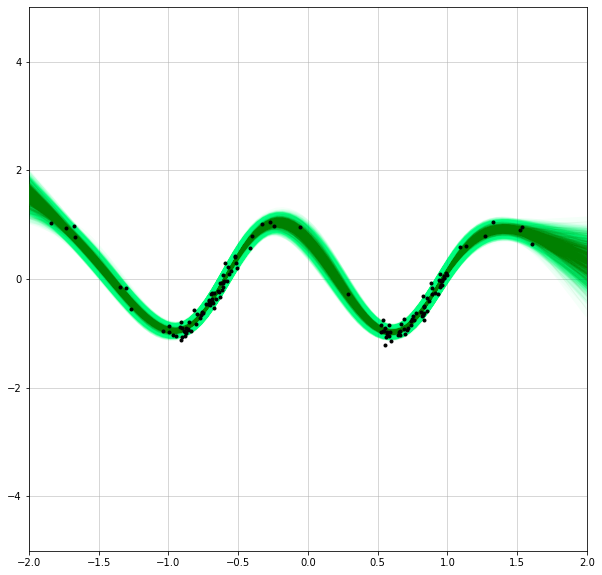

In [5]:
fig=setup.makePlot(theta_HMC[0::10],device)


In [6]:
FG=BigGenerator(5,param_count, device).to(device)
FG.load_state_dict(torch.load('mlruns/44/69bc4add9cb744caa997a1128b31e921/artifacts/model.pt')['state_dict'])
theta_FG=FG(sample_size).detach()

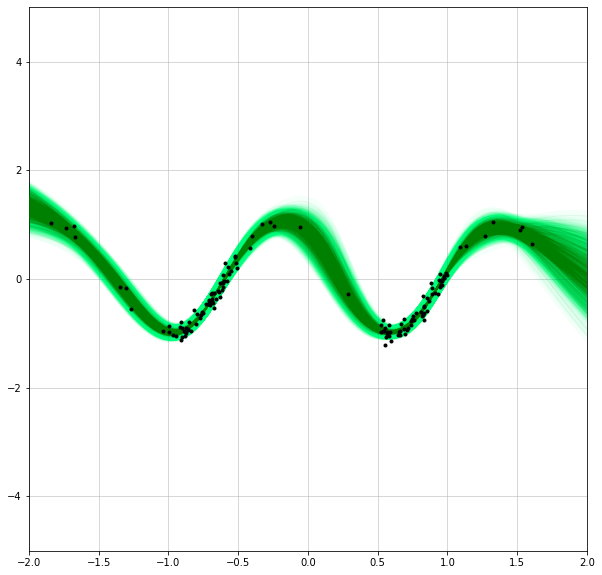

In [7]:
fig=setup.makePlot(FG(1000).detach(),device)

In [8]:
G=BigGenerator(5,param_count, device).to(device)
G.load_state_dict(torch.load('mlruns/49/03b3e1b158c344d3813b3293d34ae6cb/artifacts/model.pt')['state_dict'])
theta_G=G(sample_size).detach()

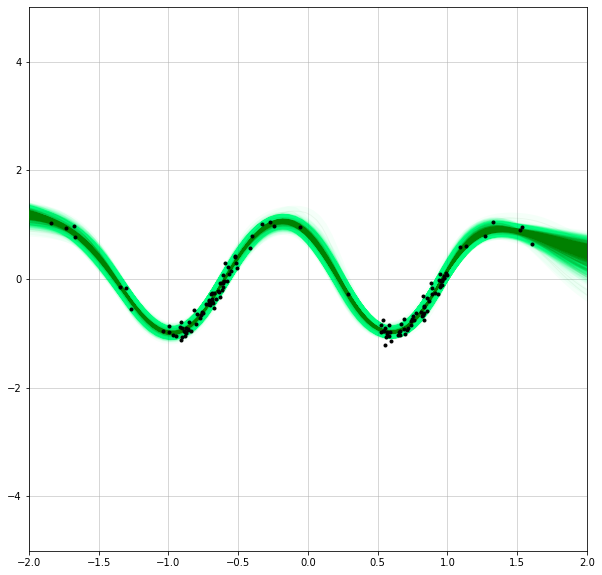

In [9]:
fig=setup.makePlot(G(1000).detach(),device)

# Parameter space #

In [10]:
models={'HMC':theta_HMC,
        'GeNNeVI':theta_G,
        'FuNNeVI':theta_FG}
for m in models:
    for n in models:
        if not n == m: 
            K=KL(models[m], models[n],k=1,device=device)
            print('KL('+m+','+n+'):'+str(K))

KL(HMC,GeNNeVI):tensor(119.3087, device='cuda:0')
KL(HMC,FuNNeVI):tensor(110.8196, device='cuda:0')
KL(GeNNeVI,HMC):tensor(220.6982, device='cuda:0')
KL(GeNNeVI,FuNNeVI):tensor(234.8820, device='cuda:0')
KL(FuNNeVI,HMC):tensor(634.2628, device='cuda:0')
KL(FuNNeVI,GeNNeVI):tensor(662.9454, device='cuda:0')


# Function space #

In [11]:
import itertools
models_pairs=list(itertools.combinations(models.items(),2))


In [29]:
def FuKL(t,s,k=1,n=100, m=20):
    assert t.shape == s.shape
    K=torch.Tensor(n)
    for i in range(n):
        t_, s_= projection(t, s, m, 1.)
        K[i]=KL(t_, s_, k=k,device=device)
    return K.mean()
print('KL in function space L_2([-2,2])')
for (m,s),(n,t) in models_pairs:
        K=FuKL(s, t)
        K_=FuKL(t,s)
        print('KL('+m+','+n+'):'+str(K.item())+'   '+'KL('+n+','+m+'):'+str(K_.item()))
        print('J('+m+','+n+'):'+str(0.5*(K.item()+K_.item())))

KL in function space L_2([-2,2])
KL(HMC,GeNNeVI):22.087961196899414   KL(GeNNeVI,HMC):26.485309600830078
J(HMC,GeNNeVI):24.286635398864746
KL(HMC,FuNNeVI):9.71174430847168   KL(FuNNeVI,HMC):15.054049491882324
J(HMC,FuNNeVI):12.382896900177002
KL(GeNNeVI,FuNNeVI):30.180082321166992   KL(FuNNeVI,GeNNeVI):20.888713836669922
J(GeNNeVI,FuNNeVI):25.534398078918457


# Predictive space #

In [18]:
import scipy.stats as st

def pred_div(s,t,X):
    J=torch.Tensor(X.shape[0])
    K=torch.Tensor(X.shape[0])
    K_=torch.Tensor(X.shape[0])
    W=torch.Tensor(X.shape[0])
    for x in range(X.shape[0]):
        K[x]=KL(s[:,x].unsqueeze(-1),t[:,x].unsqueeze(-1),k=300)
        K_[x]=KL(t[:,x].unsqueeze(-1),s[:,x].unsqueeze(-1),k=300)
        W[x]=st.wasserstein_distance(s[:,x].cpu().numpy(),t[:,x].cpu().numpy())
    J=0.5*(K+K_)
    return [K, K_, J, W]

In [19]:
X=torch.linspace(-2,2,100).to(device)
t=model(X,models['HMC']).squeeze()
s=model(X,models['GeNNeVI']).squeeze()
metrics_GE=pred_div(s,t,X)

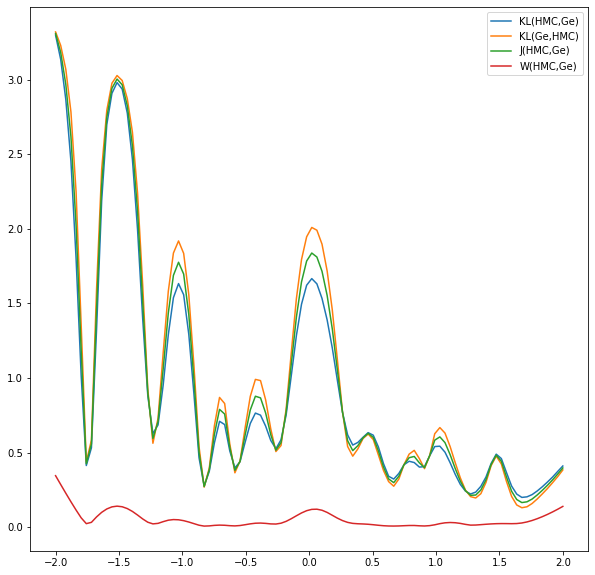

In [20]:
plt.subplots(figsize=(10,10))
for m in metrics_GE:
    plt.plot(X.cpu(),m.cpu())
plt.legend(['KL(HMC,Ge)','KL(Ge,HMC)','J(HMC,Ge)', 'W(HMC,Ge)'])


In [25]:
X=torch.linspace(-2,2,100).to(device)
t=model(X,models['HMC']).squeeze()
s=model(X,models['FuNNeVI']).squeeze()
metrics_FU=pred_div(s,t,X)

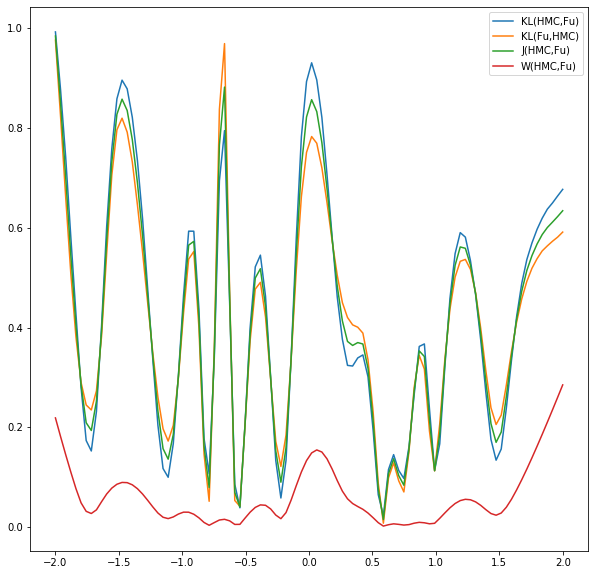

In [26]:
plt.subplots(figsize=(10,10))
for m in metrics_FU:
    plt.plot(X.cpu(),m.cpu())
plt.legend(['KL(HMC,Fu)','KL(Fu,HMC)','J(HMC,Fu)', 'W(HMC,Fu)'])


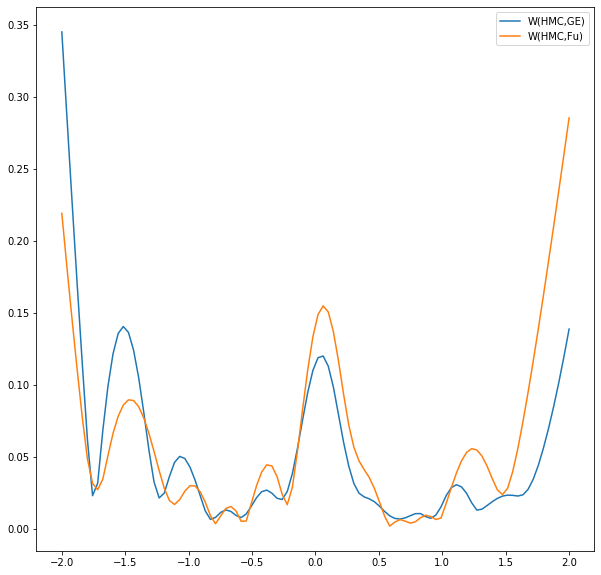

In [27]:
plt.subplots(figsize=(10,10))
plt.plot(X.cpu(),metrics_GE[3].cpu())
plt.plot(X.cpu(),metrics_FU[3].cpu())
plt.legend( ['W(HMC,GE)', 'W(HMC,Fu)'])

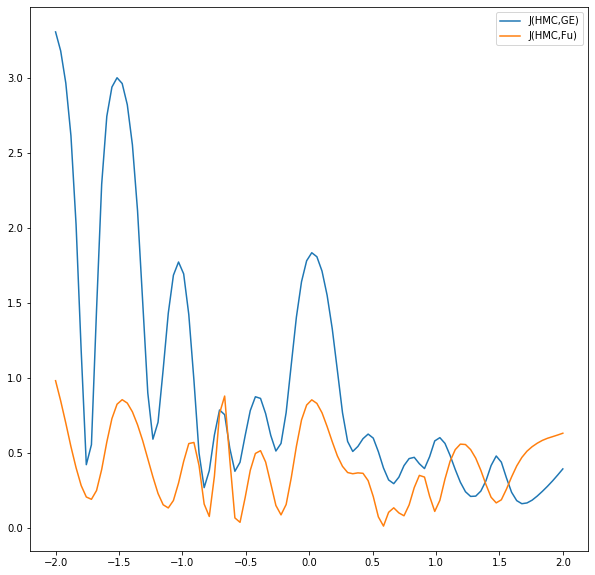

In [28]:
plt.subplots(figsize=(10,10))
plt.plot(X.cpu(),metrics_GE[2].cpu())
plt.plot(X.cpu(),metrics_FU[2].cpu())
plt.legend( ['J(HMC,GE)', 'J(HMC,Fu)'])

# t-sne

In [21]:
X=torch.linspace(-2,2,100).to(device)
t=model(X,models['HMC']).squeeze()
s=model(X,models['FuNNeVI']).squeeze()
metrics_FU=pred_div(s,t,X)

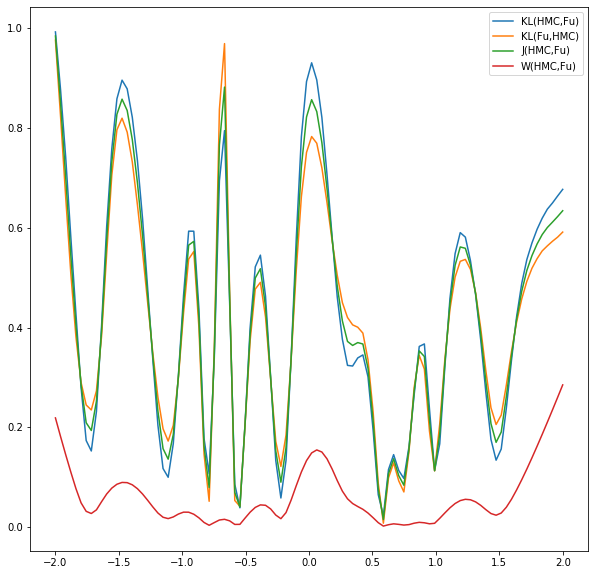

In [22]:
plt.subplots(figsize=(10,10))
for m in metrics_FU:
    plt.plot(X.cpu(),m.cpu())
plt.legend(['KL(HMC,Fu)','KL(Fu,HMC)','J(HMC,Fu)', 'W(HMC,Fu)'])


In [13]:
thetas=[theta_HMC,theta_G,theta_FG]
thetas=[t[::10] for t in thetas]

size_sample=thetas[0].shape[0]

theta=torch.cat(thetas,dim=0)
colors=torch.cat([torch.zeros(size_sample),0.1*torch.ones(size_sample),0.2*torch.ones(size_sample)])
theta.shape

torch.Size([3000, 151])

In [14]:
from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=2,init='pca',perplexity=100)
X_embedded_ =myTSNE.fit_transform(theta.cpu())
print(myTSNE.kl_divergence_)
X_embedded_.shape

1.2066376209259033


(3000, 2)

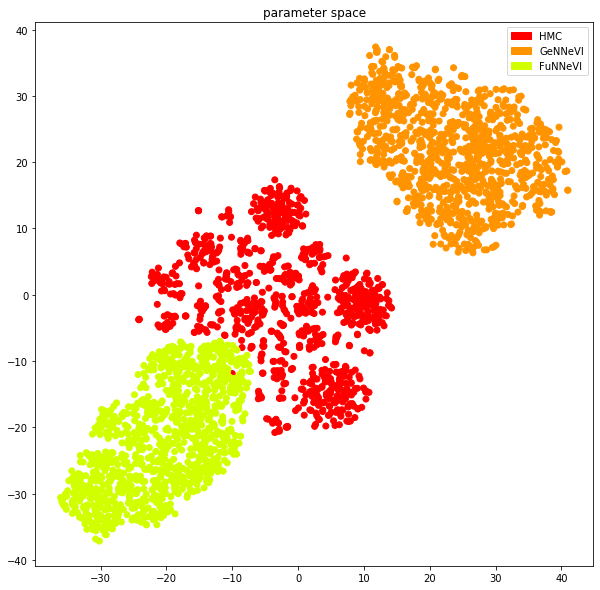

In [15]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import matplotlib.patches as mpatches

import matplotlib.cm as cm
cmap = cm.hsv


fig = plt.figure(figsize=(10, 10))




G1_patch = mpatches.Patch(color=cmap(0.), label='HMC')
G2_patch = mpatches.Patch(color=cmap(0.1), label='GeNNeVI')
G3_patch = mpatches.Patch(color=cmap(0.2), label='FuNNeVI')



#ax = fig.gca(projection='3d')
plt.scatter(X_embedded_[:,0],X_embedded_[:,1],color=cmap(colors),cmap=cmap) #,X_embedded_[:,2]
#plt.title('3D t-SNE of '+str(param_count)+'-dimensional transformed noise')
#ax.view_init(elev=20., azim=270)

plt.legend(handles=[G1_patch,G2_patch,G3_patch])
plt.title('parameter space')
plt.show()


In [16]:
X=torch.linspace(-2,2,100).to(device)
thetas_proj=[model(X,t).squeeze() for t in thetas]
theta_proj=torch.cat(thetas_proj,dim=0)


In [25]:
from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=2,init='pca',perplexity=50)
X_embedded_proj =myTSNE.fit_transform(theta_proj.cpu())
print(myTSNE.kl_divergence_)
X_embedded_.shape

1.2830486297607422


(3000, 2)

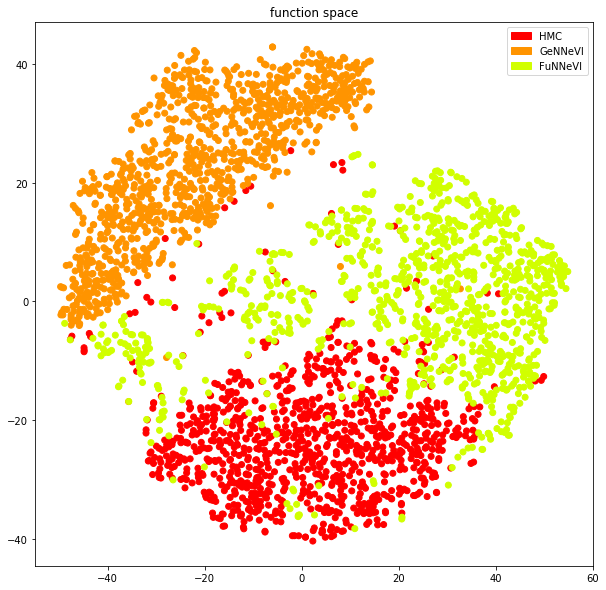

In [26]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import matplotlib.patches as mpatches

import matplotlib.cm as cm
cmap = cm.hsv


fig = plt.figure(figsize=(10, 10))



G1_patch = mpatches.Patch(color=cmap(0.), label='HMC')
G2_patch = mpatches.Patch(color=cmap(0.1), label='GeNNeVI')
G3_patch = mpatches.Patch(color=cmap(0.2), label='FuNNeVI')


#ax = fig.gca(projection='3d')
plt.scatter(X_embedded_proj[:,0],X_embedded_proj[:,1],color=cmap(colors),cmap=cmap) #,X_embedded_[:,2]
#plt.title('3D t-SNE of '+str(param_count)+'-dimensional transformed noise')
#ax.view_init(elev=20., azim=270)

plt.legend(handles=[G1_patch,G2_patch,G3_patch])
plt.title('function space')
plt.show()
